In [43]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import *
from lmfit.models import LorentzianModel

['Time (s)', 'Signal']


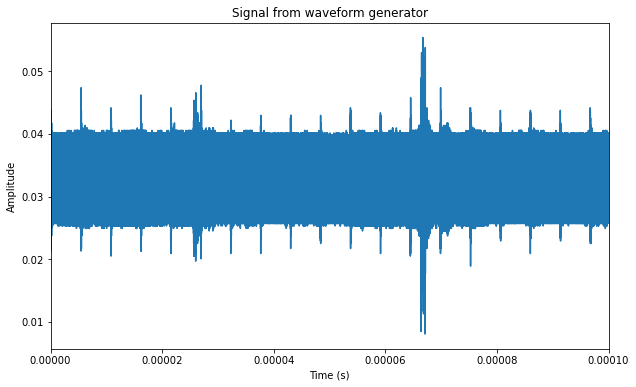

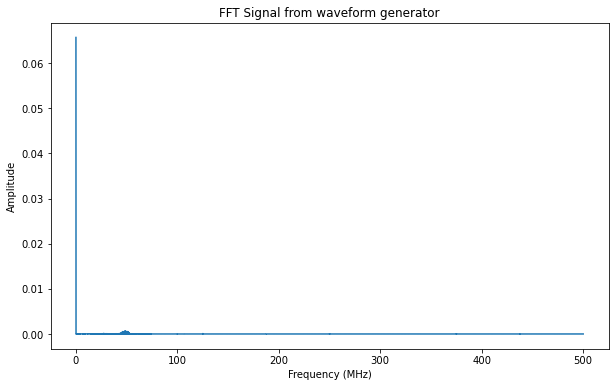

In [34]:
# Beat signal
sample=pd.read_csv(r'D:/Thesis 4th year/Oscilloscope/230219/R3J0t500us.csv').iloc[0:,1:2]
#sample=pd.read_csv(r'D:/Thesis 4th year/Oscilloscope/230212/N1t500us.csv').iloc[0:,1:2]
nsamples = len(sample)

# ----------------
# Time
# ----------------
dt = 1.e-9
t = pd.Series([i*dt for i in range(nsamples)], name='Time (s)').T

df_sample = pd.DataFrame(t)
df_sample['Signal']=sample


header = list(df_sample.columns)
print(header)

fig1,ax1 = plt.subplots(figsize=(10,6))
ax1.plot(df_sample['Time (s)'],df_sample['Signal'],'-')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0,100e-6)
plt.title('Signal from waveform generator')
plt.show()

yf = fft(df_sample['Signal'].values)
xf = fftfreq(nsamples, dt)[:nsamples//2]

fig2,ax2 = plt.subplots(figsize=(10,6))
ax2.plot(xf*1e-6, 2.0/nsamples * np.abs(yf[0:nsamples//2]))
plt.title('FFT Signal from waveform generator')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')
# plt.xlim(0,1e-9)
#plt.grid()
plt.show()

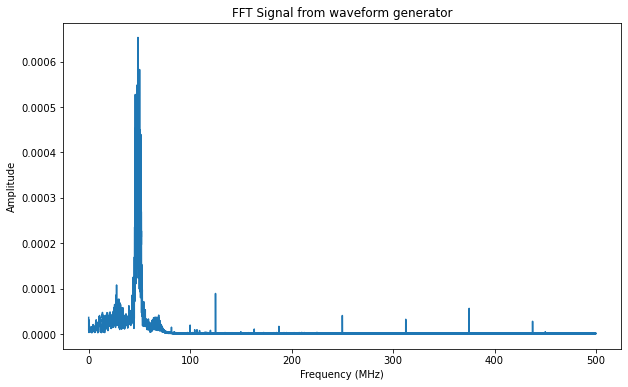

In [36]:
# Peakfinder

peaks, _ = find_peaks(2.0/nsamples * np.abs(yf[0:nsamples//2]))

peakfreq = pd.Series(xf[peaks]*1e-6,name='Frequency(MHz)')
peakamp = pd.Series(2.0/nsamples * np.abs(yf[0:nsamples//2])[peaks], name='Amplitude')

df_peak = pd.DataFrame(peakfreq)
df_peak['Amplitude']=peakamp

df_peak[df_peak.Amplitude > 0.00004]

fig3,ax3 = plt.subplots(figsize=(10,6))
# ax3.plot(df_peak['Frequency(MHz)'],df_peak['Amplitude'])
ax3.plot(peakfreq,peakamp)
plt.title('FFT Signal from waveform generator')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')
# plt.xlim(0,1)
#plt.grid()
plt.show()

In [31]:
df_peak

,Frequency(MHz),Amplitude
0,0.022888,0.000268
1,0.061035,0.000075
2,0.099182,0.000052
3,0.129700,0.000048
4,0.144958,0.000049
...,...,...
21833,499.900818,0.000001
21834,499.916077,0.000002
21835,499.938965,0.000002
21836,499.954224,0.000002


In [30]:
xf[:8]-xf[1:9]

array([-7629.39453125, -7629.39453125, -7629.39453125, -7629.39453125,
       -7629.39453125, -7629.39453125, -7629.39453125, -7629.39453125])

In [29]:
import plotly.express as px
fig = px.line(xf*1e-6, 2.0/nsamples * np.abs(yf[0:nsamples//2]))
fig.show()

In [46]:
def FFT3D(C,n,times):
    if times/500e-6==1: # 500us
        a=500
        text='u'
    elif times/10e-3==1: # 10ms
        a=10
        text='m'
    elif times/100e-9==1: # 100ns
        a=100
        text='n'
    elif times/1e-6==1: # 1us
        a=1
        text='u'
    else:
        print('No such file or directory')
    
    sample=pd.read_csv(r'D:/Thesis 4th year/Oscilloscope/230219/'+str(C)+''+str(n)+'t'+str(a)+''+str(text)+'s.csv').iloc[0:,1:2]
    print('file name: '+str(C)+''+str(n)+'t'+str(a)+''+str(text)+'s')
    
    nsamples = len(sample)
    
    if times == 500e-6:
        dt = 1.e-9 # 1/(1GSa/s) or 1/1.e9 
    elif times == 100e-9:
        dt = 1.e-9
    elif times == 1e-3:
        dt = 1/500.e6 #1/(500MSa/s)
    
    t = pd.Series([i*dt for i in range(nsamples)], name='Time (s)').T  
    df_sample = pd.DataFrame(t)
    df_sample['Signal']=sample
    header = list(df_sample.columns)
    
    yf = fft(df_sample['Signal'].values)
    xf = fftfreq(nsamples, dt)[:nsamples//2]
    
    # Peakfinder
    peaks, _ = find_peaks(2.0/nsamples * np.abs(yf[0:nsamples//2]))

    peakfreq = pd.Series(xf[peaks]*1e-6,name='Frequency(MHz)')
    peakamp = pd.Series(2.0/nsamples * np.abs(yf[0:nsamples//2])[peaks], name='Amplitude')

    df_peak = pd.DataFrame(peakfreq)
    df_peak['Amplitude']=peakamp
    df_peak[df_peak.Amplitude > 0.00000]
    
    return peakfreq,peakamp

def lff(A):
    x=A[0]
    X=x
    Y=A[1].values.flatten()
    mod = LorentzianModel()
    pars = mod.guess(Y, x=X)
    out = mod.fit(Y, pars, x=X)
    a=out.params['amplitude'].value
    c=out.params['center'].value
    s=out.params['sigma'].value
    f=out.params['fwhm'].value
    return a,c,s,f

def plotFFT(A,a,c,s,f):
    x=A[0]
    mu=c
    sigma=s
    fwhm=f
    lor=(a/(np.pi))*(sigma/((x-mu)**2+sigma**2))
    fig, ax = plt.subplots(figsize=(15, 9))
    plt.plot(A[0],A[1])
    plt.plot(A[0],lor,"--")
    plt.xlim(0)
    #linewidth=(0.0152587890625*10e6*fwhm) #600 data point
    #print('linewidth :',f,'MHz')
    return 

def FFTP(C,n,times):
    A=FFT3D(C,n,times)
    A1=lff(FFT3D(C,n,times))
    print('linewidth :',A1[3],'MHz')
    plotFFT(A,A1[0],A1[1],A1[2],A1[3])
    return

file name: R3J8t500us
file name: R3J8t500us
linewidth : 5.28777420124962 MHz


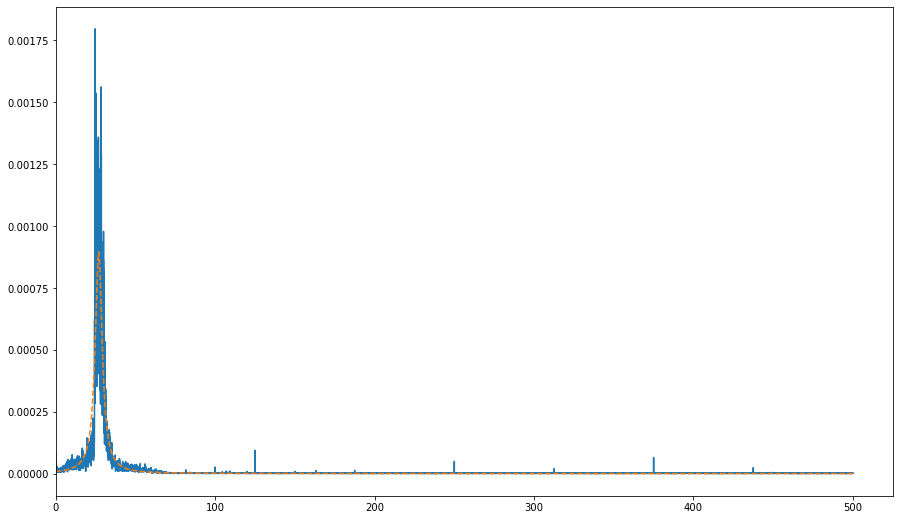

In [63]:
FFTP('R3J',8,500e-6)

In [64]:
fig, axs = plt.subplots(2,5, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.08, wspace=.01)

axs = axs.ravel()

for i in range(10):
    axs[i].plot(FFT3D('R3J',i,500e-6)[0],FFT3D('R3J',i,500e-6)[1])
    axs[i].set_title(str(i))

In [68]:
def plotFFT1(A,a,c,s,f):
    x=A[0]
    mu=c
    sigma=s
    fwhm=f
    lor=(a/(np.pi))*(sigma/((x-mu)**2+sigma**2))
    fig, ax = plt.subplots(figsize=(15, 9))
    plt.plot(A[0],A[1])
    plt.plot(A[0],lor,"--")
    plt.xlim(0,100)
    return 

def FFTP1(C,n,times):
    A=FFT3D(C,n,times)
    A1=lff(FFT3D(C,n,times))
    print('linewidth :',A1[3],'MHz')
    plotFFT1(A,A1[0],A1[1],A1[2],A1[3])
    return

file name: R3J1t500us
file name: R3J1t500us
linewidth : 5.864941191777139 MHz


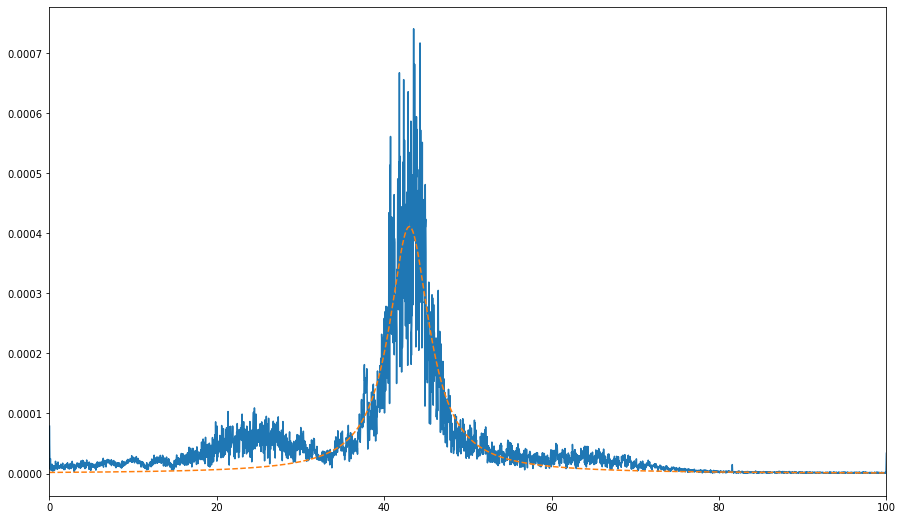

In [69]:
FFTP1('R3J',1,500e-6)

In [208]:
def FFT3D1(C,n,times):
    if times/500e-6==1: # 500us
        a=500
        text='u'
    elif times/10e-3==1: # 10ms
        a=10
        text='m'
    elif times/100e-9==1: # 100ns
        a=100
        text='n'
    elif times/1e-6==1: # 1us
        a=1
        text='u'
    else:
        print('No such file or directory')
    
    sample=pd.read_csv(r'D:/Thesis 4th year/Oscilloscope/230219/'+str(C)+''+str(n)+'t'+str(a)+''+str(text)+'s.csv').iloc[0:,1:2]
    print('file name: '+str(C)+''+str(n)+'t'+str(a)+''+str(text)+'s')
    
    nsamples = len(sample)
    
    if times == 500e-6:
        dt = 1.e-9 # 1/(1GSa/s) or 1/1.e9 
    elif times == 100e-9:
        dt = 1.e-9
    elif times == 1e-3:
        dt = 1/500.e6 #1/(500MSa/s)
    
    t = pd.Series([i*dt for i in range(nsamples)], name='Time (s)').T  
    df_sample = pd.DataFrame(t)
    df_sample['Signal']=sample
    header = list(df_sample.columns)
    
    yf = fft(df_sample['Signal'].values)
    xf = fftfreq(nsamples, dt)[:nsamples//2]
    
    # Peakfinder
    peaks, _ = find_peaks(2.0/nsamples * np.abs(yf[0:nsamples//2]))

    peakfreq = pd.Series(xf[peaks]*1e-6,name='Frequency(MHz)')
    peakamp = pd.Series(2.0/nsamples * np.abs(yf[0:nsamples//2])[peaks], name='Amplitude')

    df_peak = pd.DataFrame(peakfreq)
    df_peak['Amplitude']=peakamp
    df_peak[df_peak.Amplitude > 0.00000]
    
    return peakfreq,peakamp


In [284]:
df_sample1=pd.read_csv(r'D:/Thesis 4th year/Oscilloscope/230219/R3J3t500us.csv').iloc[0:,1:2]
nsamples=len(df_sample1)
t = pd.Series([i*dt for i in range(nsamples)], name='Time (s)').T  
df_sample1 = pd.DataFrame(t)
df_sample1['Signal']=sample
#df1=df_sample.drop(df_sample.index[3500:])
#df1=df1.drop(df_sample.index[3501:])
df1=df_sample1

In [285]:
df1

,Time (s),Signal
0,0.000000e+00,0.027708
1,1.000000e-09,0.029716
2,2.000000e-09,0.031723
3,3.000000e-09,0.033731
4,4.000000e-09,0.034936
...,...,...
131067,1.310670e-04,0.020078
131068,1.310680e-04,0.020078
131069,1.310690e-04,0.020881
131070,1.310700e-04,0.022487


In [286]:
nsamples = len(df1)
dt = 1.e-9 # 1/(1GSa/s) or 1/1.e9 
t = pd.Series([i*dt for i in range(nsamples)], name='Time (s)').T  
df_sample = pd.DataFrame(t)
df_sample['Signal']=sample
header = list(df_sample.columns)
    
yf = fft(df1['Signal'].values)
xf = fftfreq(nsamples, dt)[:nsamples//2]
    
# Peakfinder
peaks, _ = find_peaks(2.0/nsamples * np.abs(yf[0:nsamples//2]))

peakfreq = pd.Series(xf[peaks]*1e-6,name='Frequency(MHz)')
peakamp = pd.Series(2.0/nsamples * np.abs(yf[0:nsamples//2])[peaks], name='Amplitude')

df_peak = pd.DataFrame(peakfreq)
df_peak['Amplitude']=peakamp
#df_peak[df_peak.Amplitude > 0.00000]

(0.0, 100.0)

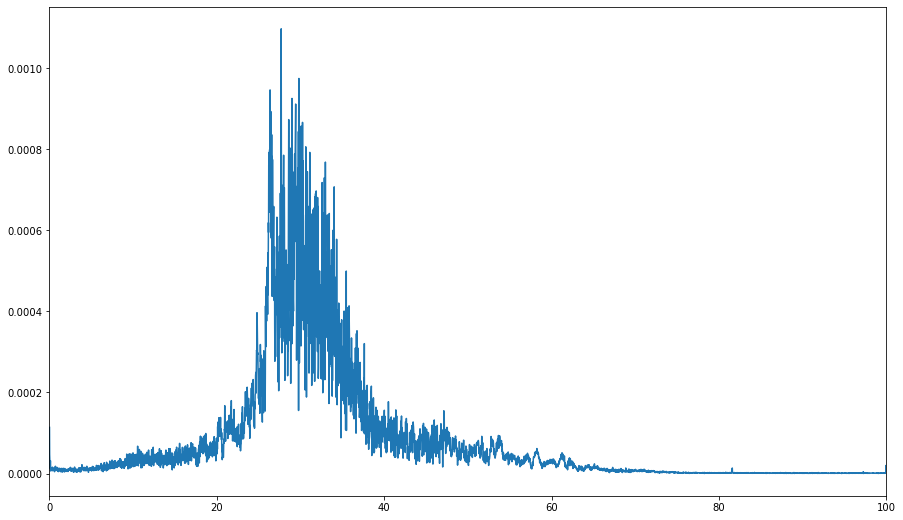

In [287]:
plt.subplots(figsize=(15,9))
plt.plot(peakfreq,peakamp)
plt.xlim(0,100)